In [1]:
import torch
import numpy as np
import random
from relaxed_gconv import RelaxedRotCNN2d
from utils import train_model
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## 1. Create Synthetic Data

In [3]:
# D4
square_image = torch.zeros((9,9))
square_image[2,2] = 1.0
square_image[2,6] = 1.0
square_image[6,2] = 1.0
square_image[6,6] = 1.0
square_image = square_image[None, None]

# D2
rect_image = torch.zeros((9,9))
rect_image[1,3] = 1.0
rect_image[1,5] = 1.0
rect_image[7,3] = 1.0
rect_image[7,5] = 1.0
rect_image = rect_image[None, None]

# Random
rand_image = torch.zeros((9,9))
rand_image[1,3] = 1.0
rand_image[1,7] = 1.0
rand_image[7,3] = 1.0
rand_image[7,5] = 1.0
rand_image = rand_image[None, None]

##  2. Finding Symmetry Breaking with ***Relaxed*** Group Convolution

In [4]:
# Square to Square
Relaxed_GConvNet_SS = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 4, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
__ = train_model(model = Relaxed_GConvNet_SS, inp = square_image.to(device), tgt = square_image.to(device))

# # Square to Rectangle
Relaxed_GConvNet_SR = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 8, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
__ = train_model(model = Relaxed_GConvNet_SR, inp = square_image.to(device), tgt = rect_image.to(device))

# # Square to Non-symmetric shape
Relaxed_GConvNet_SN = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 8, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
__ = train_model(model = Relaxed_GConvNet_SN, inp = square_image.to(device), tgt = rand_image.to(device))

/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1 | MSE: 0.04952
Epoch 51 | MSE: 0.00003
Epoch 1 | MSE: 0.04939
Epoch 51 | MSE: 0.01529
Epoch 1 | MSE: 0.04924
Epoch 51 | MSE: 0.00719


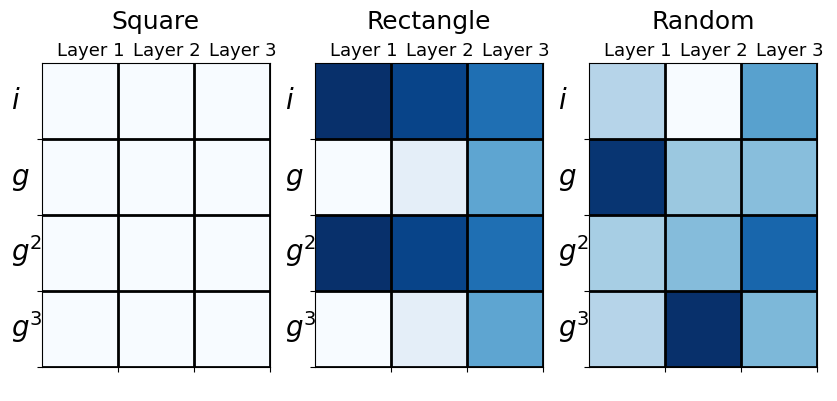

In [5]:
relaxed_weights_ss = torch.stack([Relaxed_GConvNet_SS.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights_sr = torch.stack([Relaxed_GConvNet_SR.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights_sn = torch.stack([Relaxed_GConvNet_SN.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights = [relaxed_weights_ss, relaxed_weights_sr, relaxed_weights_sn]
titles = ["Square", "Rectangle", "Random"]
fig=plt.figure(figsize=(10, 5))
for i in range(1, 4):
    fig.add_subplot(1, 3, i)
    plt.imshow(relaxed_weights[i-1], cmap = 'Blues')
    plt.xticks(np.arange(0.5,3,1), color='w')
    plt.yticks(np.arange(0.5,4,1), color='w')
    plt.text(-0.9, 0.1, "$i$", fontsize=20)
    plt.text(-0.9, 1.1, "$g$", fontsize=20)
    plt.text(-0.9, 2.1, "$g^2$", fontsize=20)
    plt.text(-0.9, 3.1, "$g^3$", fontsize=20)
    plt.text(-0.3, -0.6, "Layer 1", fontsize=13)
    plt.text(0.7, -0.6, "Layer 2", fontsize=13)
    plt.text(1.7, -0.6, "Layer 3", fontsize=13)
    plt.grid(color='black', linestyle='-', linewidth=2)
    plt.title(titles[i-1], size = 18, pad=25)
plt.show()

## 3. Projecting the relaxed weights onto the irreps of the group

In [6]:
# Character Table
c4_ft = np.array([[1, 1, 1, 1],
                  [1, -1, 1, -1],
                  [1, 0+1j, -1, 0-1j],
                  [1, 0-1j, -1, 0+1j]])

fourier_components_ss = np.round(relaxed_weights_ss[:,0] @ c4_ft.T, decimals = 3)
fourier_components_sr = np.round(relaxed_weights_sr[:,0] @ c4_ft.T, decimals = 3)
fourier_components_sn = np.round(relaxed_weights_sn[:,0] @ c4_ft.T, decimals = 3)

#### Only trivial irrep A is non zero when the output is an square

In [7]:
fourier_components_ss

array([4.029+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j])

#### Both A and B are non zero when the output is a rectangle

In [8]:
fourier_components_sr

array([4.047+0.j, 1.867+0.j, 0.   -0.j, 0.   +0.j])

In [25]:
def visulize_fourier_components(fourier_compnents_mag):
    # fourier_compnents = np.round(np.matmul(fourier_transform_matrix, signal), 4)
    # fourier_compnents_mag = []
    # irreps_dims = [1, 1, 1, 1]
    # index = 0
    # for i in range(4):
    #     if irreps_dims[i] > 1:
    #         fourier_compnents_mag.append(np.linalg.norm(fourier_compnents[index:index+irreps_dims[i]]))
    #     else:
    #         fourier_compnents_mag.append(fourier_compnents[index])
    #     index += irreps_dims[i]

    fig, ax = plt.subplots(figsize=(3, 2))
    # plt.title(inp + r"$\rightarrow$" + out , size = 12)#+ "(Abs + Log scale)"
    ax.tick_params(bottom=False, left=False)
    xlabel = ["A", "B", "E", "E"]
    ax.bar(x = np.arange(4), height = np.abs(fourier_compnents_mag), tick_label = xlabel)
    fig.tight_layout()
    # plt.yscale('log') 
    plt.savefig('3.png', bbox_inches='tight', dpi = 200)
    plt.show()

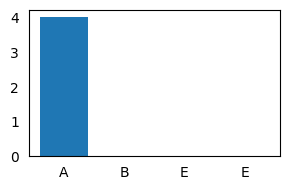

In [22]:
visulize_fourier_components(fourier_components_ss)

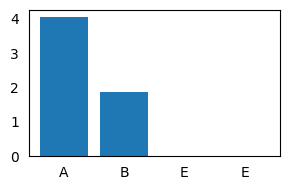

In [24]:
visulize_fourier_components(fourier_components_sr)

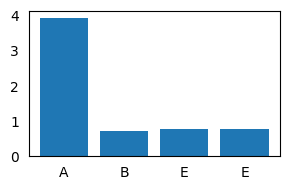

In [26]:
visulize_fourier_components(fourier_components_sn)